In [1]:
import matplotlib.pyplot as plt 
import numpy as np 
import os 
import cv2 as cv2
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage.filters import gaussian, sobel, scharr
from skimage.feature import canny
from scipy import ndimage
import random
import tensorflow as tf
from tensorflow.keras import utils
import pandas as pd
import seaborn as sns
import pickle


%matplotlib inline

2025-02-19 10:52:51.878218: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-19 10:52:51.897482: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739955171.925720 1108196 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739955171.937728 1108196 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-19 10:52:51.973403: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# Assign the drives for image data, and specify the classes / labels
train_dir = './Training'
test_dir = './Testing'
categories = ['Heart','Rectangle','Oval','Round','Square','Triangle']
nr_categories = len(categories)
label_map = {0:'Heart', 1: 'Rectangle', 2: 'Oval', 3: 'Round', 4: 'Square', 5: 'Triangle'}

In [3]:
def create_data_files(directory, array, type=None):
    '''this function reads the images from the directory and create training & testing datasets'''
    if type not in ['aspect', 'gray', 'rgb']: 
        print("Please specify image type ['aspect', 'gray', 'rgb']")
        return 
        
    i=0
    for category in categories:
        print(category)
        path = os.path.join(directory, category)  # path to directory of images
        class_num = categories.index(category)  # assign number to the 6 categories
        img_list = os.listdir(path)

        try:
            for img in img_list:
                if type == 'aspect':
                    img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)  # read in default color Grayscale
                    img_array = crop_and_resize(img_array) # call a function to crop & resize maintain aspect ratio
                    array.append([img_array, class_num])

        
                elif type == 'gray':        
                    img_array = cv2.imread(os.path.join(path,img))
                    face_array = extract_face(img_array)  # call function to extract face
                    gray_array = cv2.cvtColor(face_array,cv2.COLOR_BGR2GRAY) # convert to Gray
                    array.append([gray_array, class_num])   # 0=image, 1=class 


                elif type == 'rgb':           
                    img_array = cv2.imread(os.path.join(path,img))
                    face_array = extract_face(img_array)  # call function to extract face
                    rgb_array = cv2.cvtColor(face_array,cv2.COLOR_BGR2RGB) # convert to RGB
                    array.append([rgb_array, class_num])   # 0=image, 1=class
                    
                i += 1 
                # Print progress every 200 images
                if i % 200 == 0:
                    print(f"Images processed: {i} of {len(img_list*len(categories))}")

        except Exception as e:
                    print(f'Error: \n category: {category}\n image: {img} \n {e}')


In [4]:
def show_img(num, img_array, title, ncols=1):
    '''this function display images from an image array'''
    ncols= ncols
    nrows= int(num/ncols)
    fig, ax = plt.subplots(nrows, ncols, figsize =(ncols*4,nrows*4))
    fig.suptitle(title, size = 20)
    ax = ax.ravel()
    for i in range(num):
        ax[i].imshow(img_array[i][0], cmap='gray')
        ax[i].set_title(label_map.get(img_array[i][1]), size=16)

In [5]:
# print summaries:
def print_summary(train_array, test_array):
    print(f'\nTraining Dataset:\n')
    print(f'Shape: {train_array.shape}')
    print(f'Classes: {np.unique(train_array[:,1])}')
    print(f'No. of Images in each class: {np.bincount(train_array[:,1].astype(int))}')
    print(f'Max Pixels: {np.amax(train_array[0][0][:])}')
    print('\n--------------------------------------\n')
    print(f'\nTesting Dataset:\n')
    print(f'Shape: {test_array.shape}')
    print(f'Classes: {np.unique(test_array[:,1])}')
    print(f'No. of Images in each class: {np.bincount(test_array[:,1].astype(int))}')
    print(f'Max Pixels: {np.amax(test_array[0][0][:])}')
    print('\n--------------------------------------\n')

In [6]:
def train_test_prep(training_data_array, testing_data_array):
    
    # shuffle the images to mix all the 6 classes randomly
    random.shuffle(training_data_array)
    random.shuffle(testing_data_array)
    
    # read and split X_train, X_test, y_train, y_test into an array
    X_train = []
    y_train = []
    X_test = []
    y_test = []

    for features, label in training_data_array:
        X_train.append(features)
        y_train.append(label)

    for features, label in testing_data_array:
        X_test.append(features)
        y_test.append(label)

    # change data types/format for X
    X_train = np.array(X_train, dtype=float)
    X_test = np.array(X_test, dtype=float)

    X_train = X_train/255
    X_test = X_test/255

    # change values of y to categorical
    y_train = utils.to_categorical(y_train, nr_categories)  
    y_test = utils.to_categorical(y_test, nr_categories)

    return(X_train, X_test, y_train, y_test)

In [7]:

def pickle_out(X_train, X_test, y_train, y_test, version, data_path):
    '''to save the data out for modelling'''
    name_xtn = data_path + 'X_train_' + version +'.pickle'
    pickle_out = open(name_xtn,"wb")
    pickle.dump(X_train, pickle_out)
    pickle_out.close()

    name_ytn = data_path + 'y_train_' + version +'.pickle'
    pickle_out = open(name_ytn,"wb")
    pickle.dump(y_train, pickle_out)
    pickle_out.close()

    name_xts = data_path + 'X_test_' + version +'.pickle'
    pickle_out = open(name_xts,"wb")
    pickle.dump(X_test, pickle_out)
    pickle_out.close()

    name_yts = data_path + 'y_test_' + version +'.pickle'    
    pickle_out = open(name_yts,"wb")
    pickle.dump(y_test, pickle_out)
    pickle_out.close()

In [8]:

# create path to images in examples

ex_path = './examples'
ex_files = os.listdir(ex_path)

examples = []

for i in ex_files:
    img = os.path.join(ex_path,i)
    examples.append(img)
    
examples = sorted(examples)
examples

['./examples/Selection_294.png',
 './examples/Selection_550.png',
 './examples/index.jpeg',
 './examples/profile.jpg',
 './examples/youGuysGetting.png']

In [9]:

# Let's define a function to resize image by maintaing aspect ratio, but some parts of image will need to be cropped out

def crop_and_resize(image, target_w=224, target_h=224):
    '''this function crop & resize images to target size by keeping aspect ratio'''
    if image.ndim == 2:
        img_h, img_w = image.shape             # for Grayscale will be   img_h, img_w = img.shape
    elif image.ndim == 3:
        img_h, img_w, channels = image.shape   # for RGB will be   img_h, img_w, channels = img.shape
    target_aspect_ratio = target_w/target_h
    input_aspect_ratio = img_w/img_h

    if input_aspect_ratio > target_aspect_ratio:
        resize_w = int(input_aspect_ratio*target_h)
        resize_h = target_h
        img = cv2.resize(image, (resize_w , resize_h))
        crop_left = int((resize_w - target_w)/2)  ## crop left/right equally
        crop_right = crop_left + target_w
        new_img = img[:, crop_left:crop_right]
    if input_aspect_ratio < target_aspect_ratio:
        resize_w = target_w
        resize_h = int(target_w/input_aspect_ratio)
        img = cv2.resize(image, (resize_w , resize_h))
        crop_top = int((resize_h - target_h)/4)   ## crop the top by 1/4 and bottom by 3/4 -- can be changed
        crop_bottom = crop_top + target_h
        new_img = img[crop_top:crop_bottom, :]
    if input_aspect_ratio == target_aspect_ratio:
        new_img = cv2.resize(image, (target_w, target_h))

    return new_img

In [10]:
# portrait = cv2.imread(
#     './examples/profile.jpg', 
#     cv2.IMREAD_GRAYSCALE)
# landscape = cv2.imread(
#     './examples/index.jpeg',
#     cv2.IMREAD_GRAYSCALE)

In [11]:
# plt.imshow(portrait,cmap='gray');

In [12]:
# # auto resize by 224 - will be distorted
# resized_ptrt = cv2.resize(portrait,(224,224))
# plt.imshow(resized_ptrt, cmap='gray')

In [13]:
# # test if the function works on portrait photos
# new_ptrt = crop_and_resize(portrait)
# plt.imshow(new_ptrt,cmap='gray');

In [14]:
# # original image
# plt.imshow(landscape,cmap='gray');

In [15]:
# # auto resize by 224 - will be distorted
# resized_lscp = cv2.resize(landscape,(224,224))
# plt.imshow(resized_lscp, cmap='gray')

In [16]:
# # test if the function works on landscape photos
# new_lscp = crop_and_resize(landscape)
# plt.imshow(new_lscp,cmap='gray');

In [17]:
!pip install mtcnn
import mtcnn
from mtcnn.mtcnn import MTCNN

In [18]:
# img = cv2.imread('./examples/youGuysGetting.png')
# img2 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
# plt.imshow(img2);

In [19]:
# creates detector
detector = MTCNN()
# # detect faces in an image
# results = detector.detect_faces(img2)
# results

2025-02-19 10:52:58.149875: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [20]:
# # extract the bounding box from the face

# x1, y1, width, height = results[0]['box']
# x2, y2 = x1+width, y1+height

# face = img2[y1:y2, x1:x2]
# plt.imshow(face);

In [21]:
# print(f'x1 = {x1}')
# print(f'x2 = {x2}')
# print(f'y1 = {y1}')
# print(f'y2 = {y2}')

# # first fix the heights by adding 10 pix each side
# face_2 = img2[y1-10:y2+20, x1:x2];
# plt.imshow(face_2);

In [22]:
# # then add the width to be square
# h = (y2+20) - (y1-10)
# w = x2-x1
# print(f'h={h}')
# print(f'w={w}')

# adj_h = 10
# adj_w = int((h-w)/2)

# new_y1 = y1-adj_h
# new_y2 = y2+(adj_h*2)

# new_x1 = x1-adj_w
# new_x2 = x2+adj_w

# new_face = img2[new_y1:new_y2, new_x1:new_x2]
# plt.imshow(new_face);

In [23]:
# gray = cv2.cvtColor(new_face,cv2.COLOR_RGB2GRAY)
# plt.imshow(gray,cmap='gray');

In [24]:
# bgr = cv2.cvtColor(new_face,cv2.COLOR_RGB2BGR)
# plt.imshow(bgr);

In [25]:
# hsv = cv2.cvtColor(new_face,cv2.COLOR_RGB2HSV)
# plt.imshow(hsv,cmap='gray');

In [26]:
# entropy = entropy(gray,disk(5))
# plt.imshow(entropy,cmap='gray');

In [27]:
# blur = gaussian(new_face)
# plt.imshow(blur);

In [28]:
# scharr_img = scharr(gray)

# plt.imshow(scharr_img, cmap='gray');

In [29]:
# sobel_img = sobel(gray)
# plt.imshow(sobel_img, cmap='gray');

In [30]:
# canny_img = canny(gray, sigma = 3)
# plt.imshow(canny_img, cmap='gray');

In [31]:
# canny_img = canny(gray, sigma = 2)
# plt.imshow(canny_img, cmap='gray');

In [32]:
# canny_img = canny(gray, sigma = 1.5)
# plt.imshow(canny_img, cmap='gray');

In [33]:

def cvt_gabor(gray_img):
    ksize = 3
    sigma = 0.5
    theta = 1*np.pi/4
    lamda = 1*np.pi/4
    gamma = 0.8
    phi = 0
    
    gabor_kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, phi, ktype=cv2.CV_32F)
    gb_img = cv2.filter2D(gray_img, cv2.CV_8UC3, gabor_kernel)
    
    return(gb_img)

In [34]:
# gabor_test = cvt_gabor(gray)
# plt.imshow(gabor_test,cmap='gray');

In [35]:
# detector = MTCNN()  # creates detector  

def extract_face(img, target_size=(224,224)):
    '''this functions extract face from different images by 
    1) finds the facial bounding box 
    2) slightly expands top & bottom boundaries to include the whole face
    3) crop into a square shape
    4) resize to target image size for modelling'''
           
    # 1. detect faces in an image
      
    results = detector.detect_faces(img)
    if results == []:
        new_face = crop_and_resize(img, target_w=224, target_h=224)    
    else:
        x1, y1, width, height = results[0]['box']
        x2, y2 = x1+width, y1+height
        face = img[y1:y2, x1:x2]  # this is the face image from the bounding box before expanding bbox

        # 2. expand the top & bottom of bounding box by 10 pixels to ensure it captures the whole face
        adj_h = 10

        #assign value of new y1
        if y1-adj_h <10:
            new_y1=0
        else:
            new_y1 = y1-adj_h

        #assign value of new y2    
        if y1+height+adj_h < img.shape[0]:
            new_y2 = y1+height+adj_h
        else:
            new_y2 = img.shape[0]
        new_height = new_y2 - new_y1

        # 3. crop the image to a square image by setting the width = new_height and expand the box to new width
        adj_w = int((new_height-width)/2)    

        #assign value of new x1
        if x1-adj_w < 0:
            new_x1=0
        else:
            new_x1 = x1-adj_w

        #assign value of new x2
        if x2+adj_w > img.shape[1]:
            new_x2 = img.shape[1]
        else:
            new_x2 = x2+adj_w
        new_face = img[new_y1:new_y2, new_x1:new_x2]  # face-cropped square image based on original resolution

    # 4. resize image to the target pixel size
    sqr_img = cv2.resize(new_face, target_size)   
    return sqr_img

In [36]:

# # test the function on the examples

# n_images = len(examples)

# fig, ax = plt.subplots(nrows=7, ncols=n_images, figsize=(n_images*2.5, (7*2.5)))
# plt.gray()

# ax= ax.ravel()

# for i, file in enumerate(examples):
    
#     img = cv2.imread(file)
#     new_img = extract_face(img) # call function to extract face
    
#     rsz_img = cv2.resize(img,(224,224))
#     rsz_img = cv2.cvtColor(rsz_img,cv2.COLOR_BGR2GRAY)
#     ax[i].imshow(rsz_img)
#     ax[i].axis('off')
    
#     aspct_img = crop_and_resize(img, target_w=224, target_h=224)
#     aspct_img = cv2.cvtColor(aspct_img,cv2.COLOR_BGR2GRAY)
#     ax[i+(n_images*1)].imshow(aspct_img)
#     ax[i+(n_images*1)].axis('off')
    
#     rgb_img = cv2.cvtColor(new_img,cv2.COLOR_BGR2RGB)
#     ax[i+(n_images*3)].imshow(rgb_img)
#     ax[i+(n_images*3)].axis('off')
    
#     gray_img = cv2.cvtColor(new_img,cv2.COLOR_BGR2GRAY)
#     ax[i+(n_images*2)].imshow(gray_img)
#     ax[i+(n_images*2)].axis('off')
        
#     gabor_img = cvt_gabor(gray_img)
#     ax[i+(n_images*4)].imshow(gabor_img)
#     ax[i+(n_images*4)].axis('off')
    
#     sobel_img = sobel(gray_img)
#     ax[i+(n_images*5)].imshow(sobel_img)
#     ax[i+(n_images*5)].axis('off')
    
#     canny_img = canny(gray_img, sigma=1.5)
#     ax[i+(n_images*6)].imshow(canny_img)
#     ax[i+(n_images*6)].axis('off')
    
# plt.subplots_adjust(hspace=0.05, wspace=0.05)

# plt.figtext(x=0.105, y=0.8, s="Auto Resize", fontsize=15, rotation=90)
# plt.figtext(x=0.105, y=0.68, s="w/Aspect Ratio", fontsize=15, rotation=90)
# plt.figtext(x=0.105, y=0.6, s="BBox", fontsize=15, rotation=90)
# plt.figtext(x=0.105, y=0.48, s="BBox-RGB", fontsize=15, rotation=90)
# plt.figtext(x=0.105, y=0.37, s="BBox-Gabor", fontsize=15, rotation=90)
# plt.figtext(x=0.105, y=0.26, s="BBox-Sobel", fontsize=15, rotation=90)
# plt.figtext(x=0.105, y=0.13, s="BBox-Canny Edges", fontsize=15, rotation=90)
# plt.figtext(x=0.16, y=0.89, s="Heart", fontsize=15)
# plt.figtext(x=0.26, y=0.89, s="Oblong", fontsize=15)
# plt.figtext(x=0.38, y=0.89, s="Oval", fontsize=15)
# plt.figtext(x=0.49, y=0.89, s="Round", fontsize=15)
# plt.figtext(x=0.6, y=0.89, s="Square", fontsize=15)
# plt.figtext(x=0.68, y=0.89, s="|", fontsize=15)
# plt.figtext(x=0.7, y=0.89, s="Long Portrait", fontsize=15)
# plt.figtext(x=0.8, y=0.89, s="Wide Landscape", fontsize=15);

In [37]:
# create new training & testing data with resizing

training_data_apr = []
testing_data_apr = []

create_data_files(train_dir, training_data_apr, 'aspect')
create_data_files(test_dir, testing_data_apr, 'aspect')

Heart
Images processed: 200 of 3624
Images processed: 400 of 3624
Images processed: 600 of 3624
Rectangle
Images processed: 800 of 3600
Images processed: 1000 of 3600
Images processed: 1200 of 3600
Oval
Images processed: 1400 of 3672
Images processed: 1600 of 3672
Images processed: 1800 of 3672
Round
Images processed: 2000 of 3648
Images processed: 2200 of 3648
Images processed: 2400 of 3648
Square
Images processed: 2600 of 3564
Images processed: 2800 of 3564
Images processed: 3000 of 3564
Triangle
Images processed: 3200 of 3612
Images processed: 3400 of 3612
Images processed: 3600 of 3612
Heart
Images processed: 200 of 1212
Rectangle
Images processed: 400 of 1200
Oval
Images processed: 600 of 1224
Round
Images processed: 800 of 1200
Square
Images processed: 1000 of 1188
Triangle
Images processed: 1200 of 1200


In [38]:
X_train, X_test, y_train, y_test = train_test_prep(training_data_apr, testing_data_apr)

print(f'X_train.shape {X_train.shape}')
print(f'X_test.shape {X_test.shape}')
print(f'y_train.shape {y_train.shape}')
print(f'y_test.shape {y_test.shape}')

X_train.shape (3620, 224, 224)
X_test.shape (1204, 224, 224)
y_train.shape (3620, 6)
y_test.shape (1204, 6)


In [39]:
X_train = np.array(X_train).reshape(-1, 224, 224, 1)
X_test = np.array(X_test).reshape(-1, 224, 224, 1)

print(f'X_train.shape {X_train.shape}')
print(f'X_test.shape {X_test.shape}')
print(f'y_train.shape {y_train.shape}')
print(f'y_test.shape {y_test.shape}')

X_train.shape (3620, 224, 224, 1)
X_test.shape (1204, 224, 224, 1)
y_train.shape (3620, 6)
y_test.shape (1204, 6)


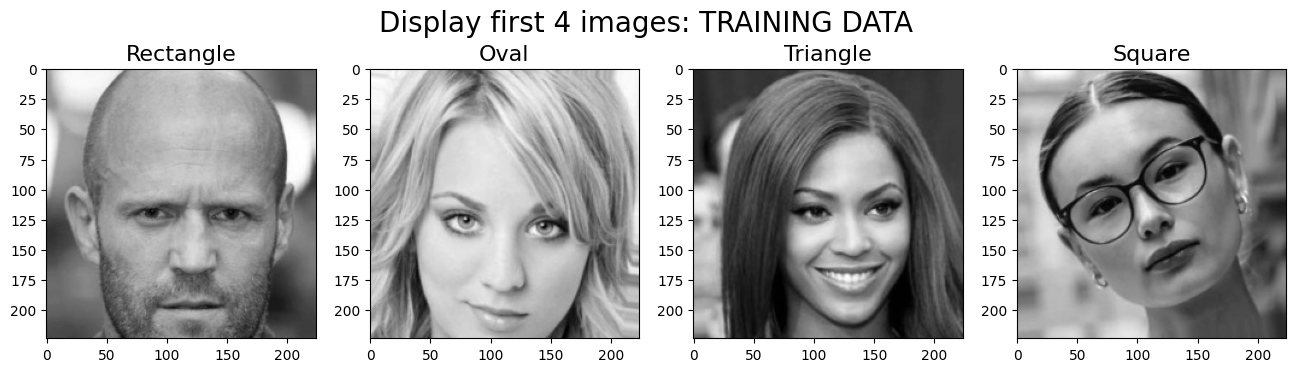

In [40]:
show_img(4, training_data_apr[:4], 'Display first 4 images: TRAINING DATA', ncols=4)

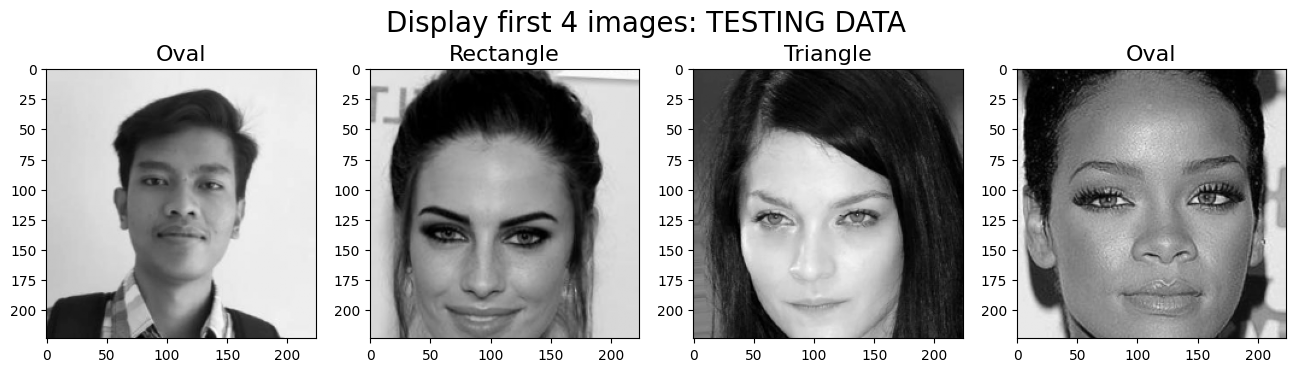

In [41]:
show_img(4, testing_data_apr[:4], 'Display first 4 images: TESTING DATA', ncols=4)

In [42]:
pickle_out(X_train, X_test, y_train, y_test, 'apr', './pickle_out/apr/pickle_out_apr')

In [43]:
# TAKES A LOT OF TIME
training_data_gray = []
testing_data_gray = []

print('Reading from: ' + train_dir)
create_data_files(train_dir, training_data_gray, 'gray')
print('Reading from: ' + test_dir)
create_data_files(test_dir, testing_data_gray, 'gray')

print(f'Training Images: {len(training_data_gray)}')
print(f'Testing Images: {len(testing_data_gray)}')

Reading from: ./Training
Heart


2025-02-19 10:53:10.403806: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [0,48,48,3] vs. [1,1,1,32]
2025-02-19 10:53:47.653706: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [0,48,48,3] vs. [1,1,1,32]


Images processed: 200 of 3624


2025-02-19 10:54:11.276452: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [0,48,48,3] vs. [1,1,1,32]


Images processed: 400 of 3624


2025-02-19 10:55:43.959748: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [0,48,48,3] vs. [1,1,1,32]


Images processed: 600 of 3624
Rectangle
Images processed: 800 of 3600
Images processed: 1000 of 3600


2025-02-19 10:57:58.751106: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [0,48,48,3] vs. [1,1,1,32]


Images processed: 1200 of 3600
Oval
Images processed: 1400 of 3672
Images processed: 1600 of 3672
Images processed: 1800 of 3672
Round
Images processed: 2000 of 3648
Images processed: 2200 of 3648


2025-02-19 11:02:55.922807: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [0,48,48,3] vs. [1,1,1,32]


Images processed: 2400 of 3648
Square
Images processed: 2600 of 3564
Images processed: 2800 of 3564
Images processed: 3000 of 3564
Triangle
Images processed: 3200 of 3612
Images processed: 3400 of 3612
Images processed: 3600 of 3612
Reading from: ./Testing
Heart
Images processed: 200 of 1212
Rectangle
Images processed: 400 of 1200
Oval
Images processed: 600 of 1224
Round


2025-02-19 11:11:21.536136: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [0,48,48,3] vs. [1,1,1,32]


Images processed: 800 of 1200
Square
Images processed: 1000 of 1188
Triangle
Images processed: 1200 of 1200
Training Images: 3620
Testing Images: 1204


In [44]:
X_train, X_test, y_train, y_test = train_test_prep(training_data_gray, testing_data_gray)

print(f'X_train.shape {X_train.shape}')
print(f'X_test.shape {X_test.shape}')
print(f'y_train.shape {y_train.shape}')
print(f'y_test.shape {y_test.shape}')

X_train.shape (3620, 224, 224)
X_test.shape (1204, 224, 224)
y_train.shape (3620, 6)
y_test.shape (1204, 6)


In [45]:
X_train = np.array(X_train).reshape(-1, 224, 224, 1)
X_test = np.array(X_test).reshape(-1, 224, 224, 1)

print(f'X_train.shape {X_train.shape}')
print(f'X_test.shape {X_test.shape}')
print(f'y_train.shape {y_train.shape}')
print(f'y_test.shape {y_test.shape}')

X_train.shape (3620, 224, 224, 1)
X_test.shape (1204, 224, 224, 1)
y_train.shape (3620, 6)
y_test.shape (1204, 6)


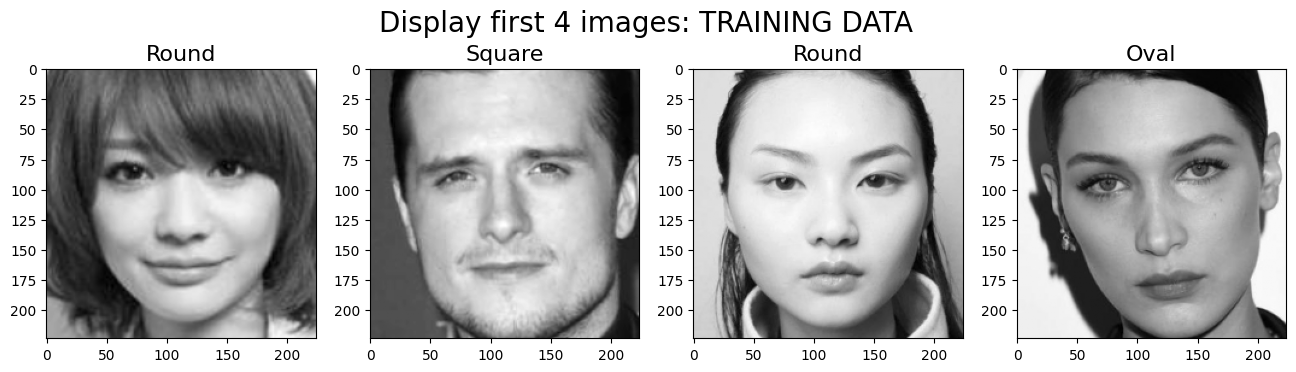

In [46]:
show_img(4, training_data_gray[4:], 'Display first 4 images: TRAINING DATA', ncols=4)

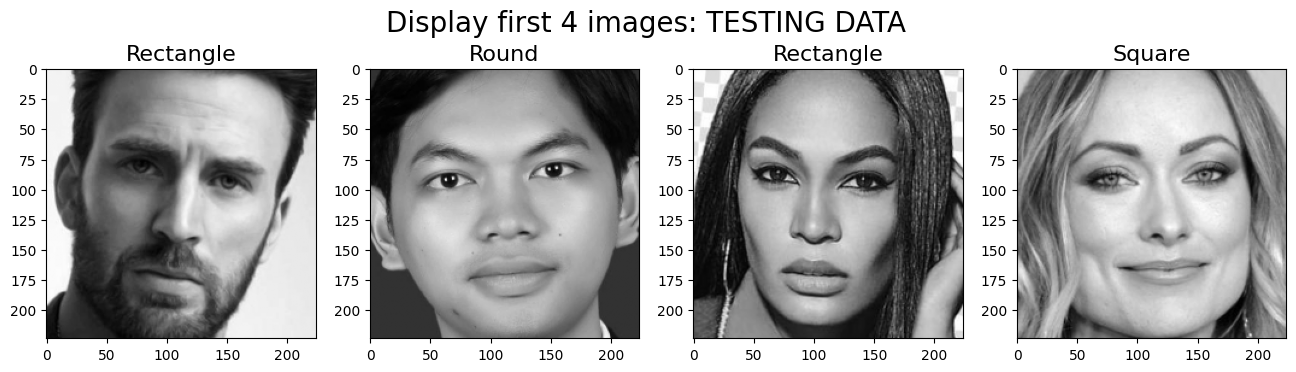

In [47]:
show_img(4, testing_data_gray[:4], 'Display first 4 images: TESTING DATA', ncols=4)

In [48]:
# need to comment out this part after running this code & generating pickle files
# otherwise it will append to existing file everytime we run it

pickle_out(X_train, X_test, y_train, y_test, 'gray', './pickle_out/gray/pickle_out_gray')

In [49]:
training_data_rgb = []
testing_data_rgb = []

create_data_files(train_dir, training_data_rgb, 'rgb')
create_data_files(test_dir, testing_data_rgb, 'rgb')

print(f'Training Images: {len(training_data_rgb)}')
print(f'Testing Images: {len(testing_data_rgb)}')

Heart
Images processed: 200 of 3624
Images processed: 400 of 3624
Images processed: 600 of 3624
Rectangle
Images processed: 800 of 3600
Images processed: 1000 of 3600
Images processed: 1200 of 3600
Oval
Images processed: 1400 of 3672
Images processed: 1600 of 3672
Images processed: 1800 of 3672
Round
Images processed: 2000 of 3648
Images processed: 2200 of 3648
Images processed: 2400 of 3648
Square
Images processed: 2600 of 3564
Images processed: 2800 of 3564
Images processed: 3000 of 3564
Triangle
Images processed: 3200 of 3612
Images processed: 3400 of 3612
Images processed: 3600 of 3612
Heart


2025-02-19 11:28:51.827343: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [0,48,48,3] vs. [1,1,1,32]


Images processed: 200 of 1212
Rectangle
Images processed: 400 of 1200
Oval
Images processed: 600 of 1224
Round
Images processed: 800 of 1200
Square
Images processed: 1000 of 1188
Triangle
Images processed: 1200 of 1200
Training Images: 3620
Testing Images: 1204


In [50]:
X_train, X_test, y_train, y_test = train_test_prep(training_data_rgb, testing_data_rgb)

In [51]:
print(f'X_train.shape {X_train.shape}')
print(f'X_test.shape {X_test.shape}')
print(f'y_train.shape {y_train.shape}')
print(f'y_test.shape {y_test.shape}')

X_train.shape (3620, 224, 224, 3)
X_test.shape (1204, 224, 224, 3)
y_train.shape (3620, 6)
y_test.shape (1204, 6)


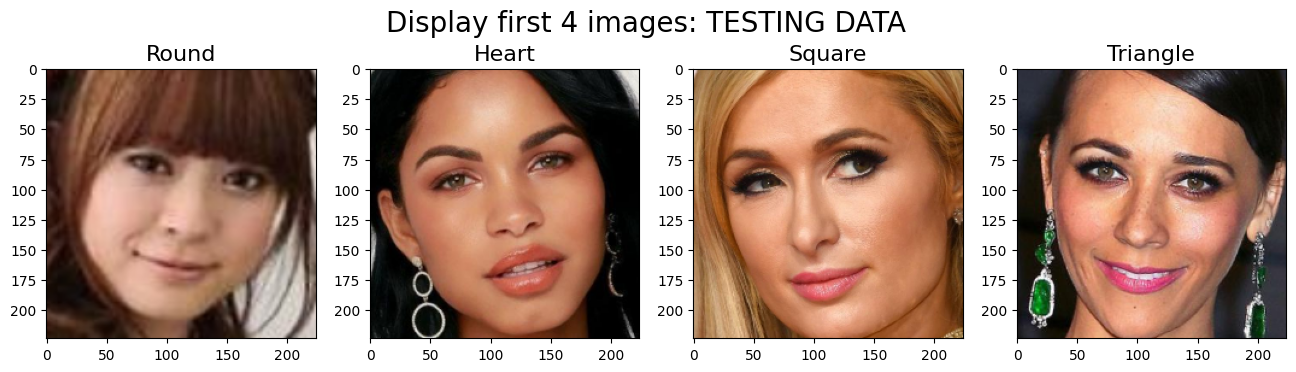

In [52]:
show_img(4, testing_data_rgb[:4], 'Display first 4 images: TESTING DATA', ncols=4)

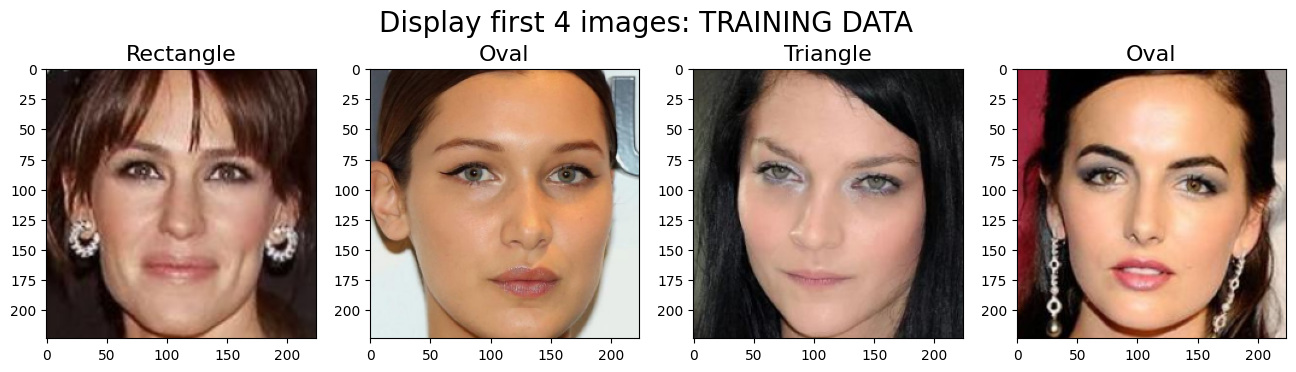

In [53]:
show_img(4, training_data_rgb[:4], 'Display first 4 images: TRAINING DATA', ncols=4)

In [ ]:
pickle_out(X_train, X_test, y_train, y_test, 'rgb', './pickle_out/rgb/pickle_out_rgb')